In [75]:
import kagglehub

#download wisconsin and coimbra datasets directly from kaggle

w_path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", w_path)


c_path = kagglehub.dataset_download("yasserhessein/breast-cancer-coimbra-data-set")

print("Path to dataset files:", c_path)


Path to dataset files: /kaggle/input/breast-cancer-wisconsin-data
Path to dataset files: /kaggle/input/breast-cancer-coimbra-data-set


In [76]:
# Install and import dependencies
!pip install kagglehub xgboost scikit-learn pandas numpy matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier


In [77]:
# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)


In [121]:
print("Coimbra dataset path:", c_path)
print("Contents of Coimbra dataset:", os.listdir(c_path))

print("Coimbra dataset path:", w_path)
print("Contents of Coimbra dataset:", os.listdir(w_path))


Coimbra dataset path: /kaggle/input/breast-cancer-coimbra-data-set
Contents of Coimbra dataset: ['dataR2.csv']
Coimbra dataset path: /kaggle/input/breast-cancer-wisconsin-data
Contents of Coimbra dataset: ['data.csv']


In [120]:
# Paths
c_path = '/kaggle/input/breast-cancer-coimbra-data-set'
w_path = '/kaggle/input/breast-cancer-wisconsin-data'

# Load the datasets
df_c = pd.read_csv(os.path.join(c_path, 'dataR2.csv'))  # Coimbra
df_w = pd.read_csv(os.path.join(w_path, 'data.csv'))    # Wisconsin



In [80]:
# Check the first few rows to understand the data structure
df_w.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [81]:
df_c.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [118]:
# Wisconsin: drop columns that are all NaN in the training set
mask_w = ~np.all(np.isnan(X_w_train), axis=0)
X_w_train = X_w_train[:, mask_w]
X_w_test  = X_w_test[:,  mask_w]

# Coimbra: same thing
mask_c = ~np.all(np.isnan(X_c_train), axis=0)
X_c_train = X_c_train[:, mask_c]
X_c_test  = X_c_test[:,  mask_c]


In [85]:
# Assuming 'Classification' is the target column in Coimbra dataset
X_c = df_c.drop('Classification', axis=1)  # Features
y_c = df_c['Classification']  # Target variable


In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_c_scaled = scaler.fit_transform(X_c)


In [87]:
# For Wisconsin dataset
df_w['diagnosis'] = df_w['diagnosis'].map({'M': 1, 'B': 0})  # Map 'M' to 1, 'B' to 0
X_w = df_w.drop(['id', 'diagnosis'], axis=1)  # Features (remove 'id' and 'diagnosis')
y_w = df_w['diagnosis']  # Target variable


In [130]:
X_w_scaled = scaler.fit_transform(X_w)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [89]:
from sklearn.model_selection import train_test_split

# Split Wisconsin data
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w_scaled, y_w, test_size=0.3, random_state=42)

# Split Coimbra data
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c_scaled, y_c, test_size=0.3, random_state=42)


In [122]:
# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# — Wisconsin —
rf_model.fit(X_w_train, y_w_train)
y_w_pred = rf_model.predict(X_w_test)

print("Random Forest Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, rf_model.predict_proba(X_w_test)[:, 1]):.4f}\n")

# — Coimbra —
rf_model.fit(X_c_train, y_c_train)
y_c_pred = rf_model.predict(X_c_test)

print("Random Forest Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, rf_model.predict_proba(X_c_test)[:, 1]):.4f}")


Random Forest Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9708
Precision: 0.9736
Recall:    0.9636
F1-score:  0.9683
ROC AUC:   0.9969

Random Forest Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.7143
Precision: 0.7141
Recall:    0.7141
F1-score:  0.7141
ROC AUC:   0.8056


In [123]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_w_train, y_w_train)

# 2) Best parameters
print("Best Parameters for Wisconsin RF:", grid_search.best_params_)

# 3) Evaluate with the best estimator
best_rf = grid_search.best_estimator_
y_w_pred = best_rf.predict(X_w_test)
y_w_proba = best_rf.predict_proba(X_w_test)[:, 1]

print("\nBest Random Forest Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, y_w_proba):.4f}")


Best Parameters for Wisconsin RF: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Best Random Forest Evaluation on Wisconsin Dataset:
Accuracy:  0.9708
Precision: 0.9736
Recall:    0.9636
F1-score:  0.9683
ROC AUC:   0.9971


In [129]:
# Wisconsin: drop any column that is entirely NaN in the training set
mask_w = ~np.all(np.isnan(X_w_train), axis=0)
X_w_train = X_w_train[:, mask_w]
X_w_test  = X_w_test[:,  mask_w]

# Coimbra: same logic
mask_c = ~np.all(np.isnan(X_c_train), axis=0)
X_c_train = X_c_train[:, mask_c]
X_c_test  = X_c_test[:, mask_c]
# Create the stacking classifier (as you already have)
estimators = [
    ('rf', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])),
    ('svm', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])),
    ('lr', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=10000, random_state=42))
    ])),
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# — Wisconsin —
stacking_model.fit(X_w_train, y_w_train)
y_w_pred = stacking_model.predict(X_w_test)
y_w_proba = stacking_model.predict_proba(X_w_test)[:, 1]

print("Stacking Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, y_w_proba):.4f}\n")

# — Coimbra —
stacking_model.fit(X_c_train, y_c_train)
y_c_pred = stacking_model.predict(X_c_test)
y_c_proba = stacking_model.predict_proba(X_c_test)[:, 1]

print(" Stacking Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, y_c_proba):.4f}")


Stacking Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9766
Precision: 0.9749
Recall:    0.9749
F1-score:  0.9749
ROC AUC:   0.9978

 Stacking Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.7714
Precision: 0.7750
Recall:    0.7696
F1-score:  0.7697
ROC AUC:   0.8301


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create a bagging classifier using RandomForest as the estimator
bagging_model = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=50, random_state=42)

# Train and evaluate on Wisconsin dataset
bagging_model.fit(X_w_train, y_w_train)
y_w_pred_bag = bagging_model.predict(X_w_test)

# Evaluate the model performance (clean style)
print("Bagging Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred_bag):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred_bag, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred_bag, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred_bag, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, bagging_model.predict_proba(X_w_test)[:, 1]):.4f}")


Bagging Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9708
Precision: 0.9736
Recall:    0.9636
F1-score:  0.9683
ROC AUC:   0.9962


In [128]:
#pipeline for Coimbra: impute → scale → bagging
bag_pipeline_c = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),             # handle NaNs
    ('scaler', StandardScaler()),                              # standardize features
    ('bag', BaggingClassifier(
        estimator=RandomForestClassifier(),
        n_estimators=50,
        random_state=42
    ))
])

# 2. Train on Coimbra training data
bag_pipeline_c.fit(X_c_train, y_c_train)

# 3. Predict and evaluate on Coimbra test data
y_c_pred_bag = bag_pipeline_c.predict(X_c_test)

print("Bagging Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred_bag):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred_bag, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred_bag, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred_bag, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, bag_pipeline_c.predict_proba(X_c_test)[:, 1]):.4f}")

Bagging Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.6857
Precision: 0.6859
Recall:    0.6846
F1-score:  0.6847
ROC AUC:   0.7778


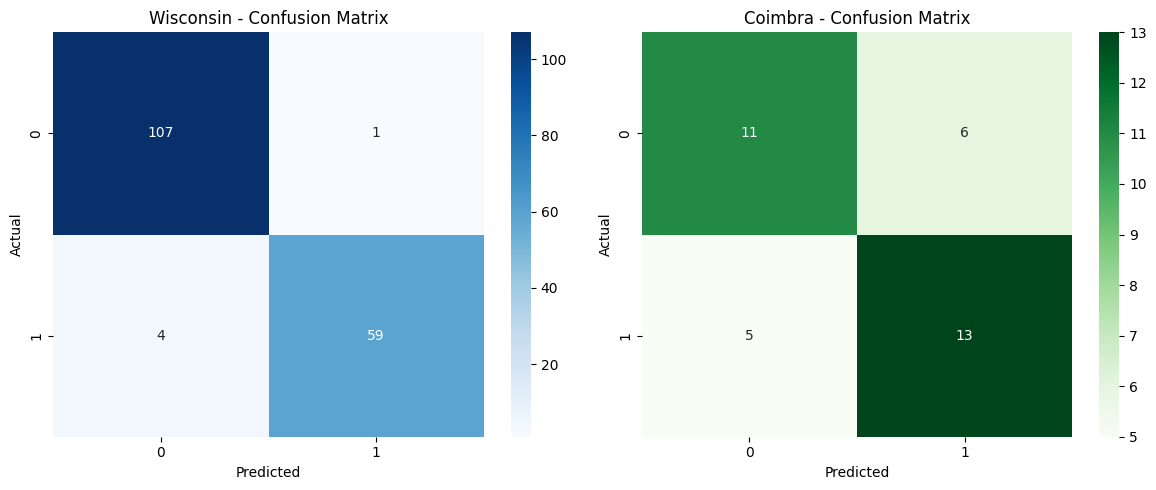

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_w = confusion_matrix(y_w_test, y_w_pred_bag)
cm_c = confusion_matrix(y_c_test, y_c_pred_bag)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Wisconsin - Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_c, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Coimbra - Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


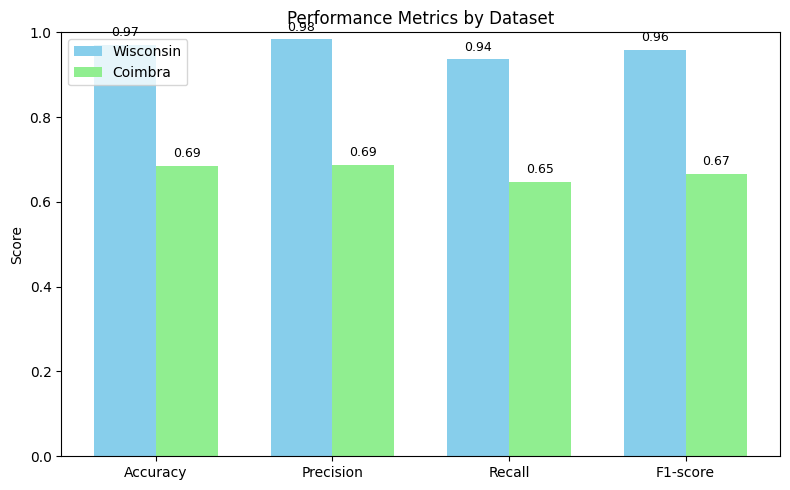

In [117]:
labels = ["Accuracy", "Precision", "Recall", "F1-score"]
wisconsin_vals = [scores_w[label] for label in labels]
coimbra_vals = [scores_c[label] for label in labels]

x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, wisconsin_vals, width, label='Wisconsin', color='skyblue')
bars2 = ax.bar(x + width/2, coimbra_vals, width, label='Coimbra', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [63]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

In [127]:
# — Wisconsin —
pipe_dt_w = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', DecisionTreeClassifier(random_state=42))
])
pipe_dt_w.fit(X_w_train, y_w_train)
y_w_pred_dt = pipe_dt_w.predict(X_w_test)

print("Decision Tree Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred_dt):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred_dt, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred_dt, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred_dt, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, pipe_dt_w.predict_proba(X_w_test)[:, 1]):.4f}\n")

# — Coimbra —
pipe_dt_c = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', DecisionTreeClassifier(random_state=42))
])
pipe_dt_c.fit(X_c_train, y_c_train)
y_c_pred_dt = pipe_dt_c.predict(X_c_test)

print("Decision Tree Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred_dt):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred_dt, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred_dt, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred_dt, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, pipe_dt_c.predict_proba(X_c_test)[:, 1]):.4f}")


Decision Tree Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9415
Precision: 0.9333
Recall:    0.9438
F1-score:  0.9380
ROC AUC:   0.9438

Decision Tree Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.7714
Precision: 0.7750
Recall:    0.7696
F1-score:  0.7697
ROC AUC:   0.7696


In [126]:
pipe_nb_w = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', GaussianNB())
])
pipe_nb_w.fit(X_w_train, y_w_train)
y_w_pred_nb = pipe_nb_w.predict(X_w_test)

print(" Naïve Bayes Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred_nb):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred_nb, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred_nb, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred_nb, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, pipe_nb_w.predict_proba(X_w_test)[:, 1]):.4f}\n")

# — Coimbra —
pipe_nb_c = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', GaussianNB())
])
pipe_nb_c.fit(X_c_train, y_c_train)
y_c_pred_nb = pipe_nb_c.predict(X_c_test)

print("Naïve Bayes Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred_nb):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred_nb, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred_nb, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred_nb, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, pipe_nb_c.predict_proba(X_c_test)[:, 1]):.4f}")


 Naïve Bayes Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9357
Precision: 0.9322
Recall:    0.9292
F1-score:  0.9307
ROC AUC:   0.9927

Naïve Bayes Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.6571
Precision: 0.7000
Recall:    0.6634
F1-score:  0.6429
ROC AUC:   0.7908


In [125]:
# — Wisconsin —
pipe_knn_w = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', KNeighborsClassifier())
])
pipe_knn_w.fit(X_w_train, y_w_train)
y_w_pred_knn = pipe_knn_w.predict(X_w_test)

print("KNN Classifier Evaluation on Wisconsin Dataset:")
print(f"Accuracy:  {accuracy_score(y_w_test, y_w_pred_knn):.4f}")
print(f"Precision: {precision_score(y_w_test, y_w_pred_knn, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_w_test, y_w_pred_knn, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_w_test, y_w_pred_knn, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_w_test, pipe_knn_w.predict_proba(X_w_test)[:, 1]):.4f}\n")

# — Coimbra —
pipe_knn_c = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', KNeighborsClassifier())
])
pipe_knn_c.fit(X_c_train, y_c_train)
y_c_pred_knn = pipe_knn_c.predict(X_c_test)

print("KNN Classifier Evaluation on Coimbra Dataset:")
print(f"Accuracy:  {accuracy_score(y_c_test, y_c_pred_knn):.4f}")
print(f"Precision: {precision_score(y_c_test, y_c_pred_knn, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_c_test, y_c_pred_knn, average='macro'):.4f}")
print(f"F1-score:  {f1_score(y_c_test, y_c_pred_knn, average='macro'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_c_test, pipe_knn_c.predict_proba(X_c_test)[:, 1]):.4f}")


KNN Classifier Evaluation on Wisconsin Dataset:
Accuracy:  0.9591
Precision: 0.9575
Recall:    0.9544
F1-score:  0.9559
ROC AUC:   0.9777

KNN Classifier Evaluation on Coimbra Dataset:
Accuracy:  0.8000
Precision: 0.8095
Recall:    0.7974
F1-score:  0.7974
ROC AUC:   0.8660


In [114]:
# Wisconsin pipelines (X_w_train, X_w_test, y_w_train, y_w_test)


pipe_dt_w = Pipeline([('imputer', SimpleImputer()), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_rf_w = Pipeline([('imputer', SimpleImputer()), ('clf', RandomForestClassifier(random_state=42))])
pipe_nb_w = Pipeline([('imputer', SimpleImputer()), ('clf', GaussianNB())])
pipe_knn_w = Pipeline([('imputer', SimpleImputer()), ('clf', KNeighborsClassifier())])

for p in (pipe_dt_w, pipe_rf_w, pipe_nb_w, pipe_knn_w):
    p.fit(X_w_train, y_w_train)

# Coimbra pipelines (X_c_train, X_c_test, y_c_train, y_c_test)
pipe_dt_c = Pipeline([('imputer', SimpleImputer()), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_rf_c = Pipeline([('imputer', SimpleImputer()), ('clf', RandomForestClassifier(random_state=42))])
pipe_nb_c = Pipeline([('imputer', SimpleImputer()), ('clf', GaussianNB())])
pipe_knn_c = Pipeline([('imputer', SimpleImputer()), ('clf', KNeighborsClassifier())])

for p in (pipe_dt_c, pipe_rf_c, pipe_nb_c, pipe_knn_c):
    p.fit(X_c_train, y_c_train)


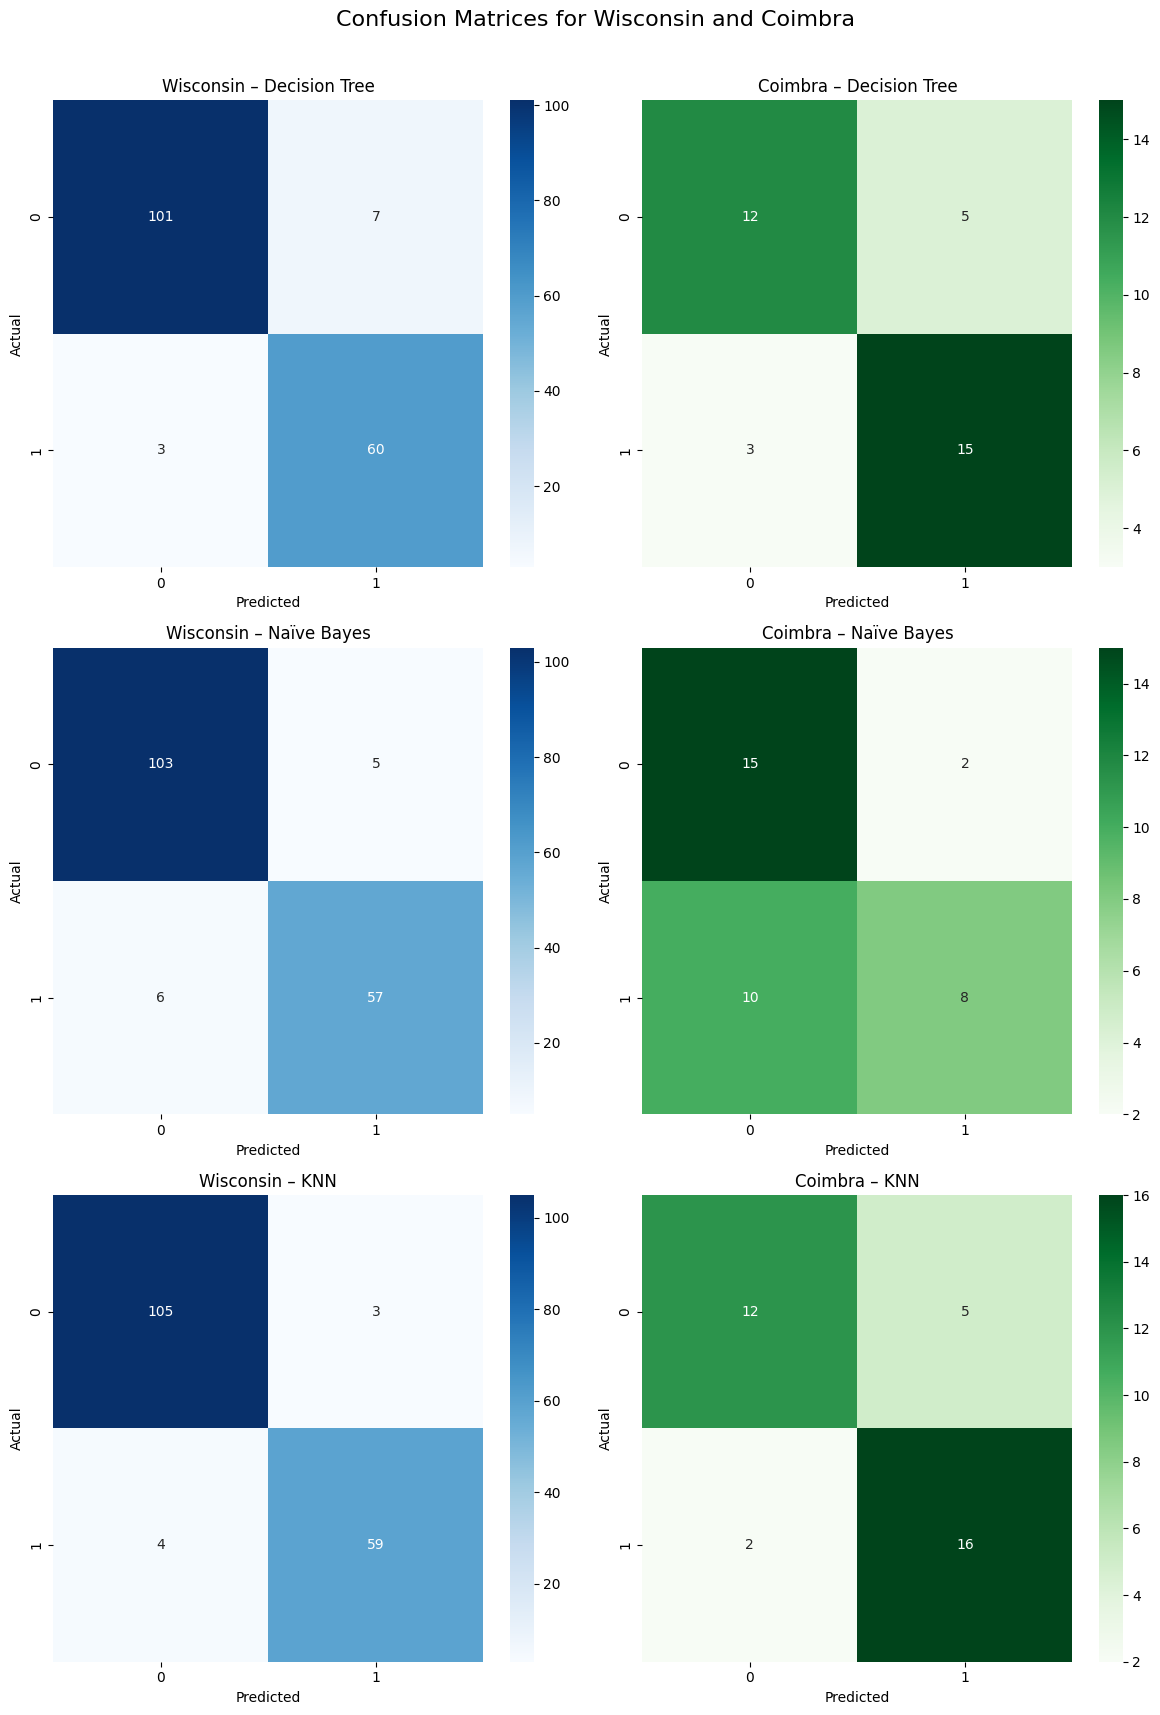

In [113]:
# Dictionary of model pipelines for each dataset
models = {
    'Decision Tree': (pipe_dt_w, pipe_dt_c),
    'Naïve Bayes':    (pipe_nb_w, pipe_nb_c),
    'KNN':             (pipe_knn_w, pipe_knn_c),
}

# Create a 3×2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.suptitle('Confusion Matrices for Wisconsin and Coimbra', fontsize=16)

for row, (name, (model_w, model_c)) in enumerate(models.items()):
    # Wisconsin
    y_w_pred = model_w.predict(X_w_test)
    cm_w = confusion_matrix(y_w_test, y_w_pred)
    ax_w = axes[row, 0]
    sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', ax=ax_w)
    ax_w.set_title(f'Wisconsin – {name}')
    ax_w.set_xlabel('Predicted')
    ax_w.set_ylabel('Actual')

    # Coimbra
    y_c_pred = model_c.predict(X_c_test)
    cm_c = confusion_matrix(y_c_test, y_c_pred)
    ax_c = axes[row, 1]
    sns.heatmap(cm_c, annot=True, fmt='d', cmap='Greens', ax=ax_c)
    ax_c.set_title(f'Coimbra – {name}')
    ax_c.set_xlabel('Predicted')
    ax_c.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # leave space for suptitle
plt.show()



In [124]:
#Define pipelines for each model and each dataset
models = {
    'Decision Tree': (
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', DecisionTreeClassifier(random_state=42))]),
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', DecisionTreeClassifier(random_state=42))])
    ),
    'Random Forest': (
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', RandomForestClassifier(random_state=42))]),
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', RandomForestClassifier(random_state=42))])
    ),
    'Naïve Bayes': (
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', GaussianNB())]),
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', GaussianNB())])
    ),
    'KNN': (
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', KNeighborsClassifier())]),
        Pipeline([('imputer', SimpleImputer(strategy='median')), ('clf', KNeighborsClassifier())])
    )
}

# 2) Fit each pipeline on its respective training data
for name, (pipe_w, pipe_c) in models.items():
    pipe_w.fit(X_w_train, y_w_train)
    pipe_c.fit(X_c_train, y_c_train)

# 3) Metric computation function
def compute_metrics(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if len(set(y_test)) == 2 else pipe.predict_proba(X_test)
    return {
        'Accuracy':    accuracy_score(y_test, y_pred),
        'Precision':   precision_score(y_test, y_pred, average='macro'),
        'Recall':      recall_score(y_test, y_pred, average='macro'),
        'F1-score':    f1_score(y_test, y_pred, average='macro'),
        'AUC':         roc_auc_score(y_test, y_proba,
                                     average='macro', multi_class='ovr')
    }

# 4) Compute metrics for Wisconsin & Coimbra
metrics_w = {}
metrics_c = {}
for name, (pipe_w, pipe_c) in models.items():
    metrics_w[name] = compute_metrics(pipe_w, X_w_test, y_w_test)
    metrics_c[name] = compute_metrics(pipe_c, X_c_test, y_c_test)

# 5) Build DataFrames
df_w = pd.DataFrame(metrics_w).T
df_w['Dataset'] = 'Wisconsin'

df_c = pd.DataFrame(metrics_c).T
df_c['Dataset'] = 'Coimbra'

df_final = pd.concat([df_w, df_c])
df_final = df_final[['Dataset','Accuracy','Precision','Recall','F1-score','AUC']]

# 6) Display the summary table
print(df_final)


                 Dataset  Accuracy  Precision    Recall  F1-score       AUC
Decision Tree  Wisconsin  0.941520   0.933338  0.943783  0.937954  0.943783
Random Forest  Wisconsin  0.970760   0.973649  0.963624  0.968259  0.996914
Naïve Bayes    Wisconsin  0.935673   0.932154  0.929233  0.930654  0.992651
KNN            Wisconsin  0.959064   0.957458  0.954365  0.955871  0.977660
Decision Tree    Coimbra  0.771429   0.775000  0.769608  0.769737  0.769608
Random Forest    Coimbra  0.714286   0.714052  0.714052  0.714052  0.805556
Naïve Bayes      Coimbra  0.657143   0.700000  0.663399  0.642857  0.790850
KNN              Coimbra  0.800000   0.809524  0.797386  0.797353  0.866013
